In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gpt_pkg.model import GPTConfig, GPT

# For latex rendering in plots
#apt-get update
#apt-get install cm-super
#apt-get install texlive-fonts-recommended
#apt-get install texlive-full


In [2]:

def estimate_gpt_params(n_layer, n_head, n_embd, non_embedding=True):
    """
    Kaplan-style param estimate: 12 * L * d^2
    """
    return int(12 * n_layer * n_embd**2)

def exact_param_count(n_layer, n_head, n_embd, non_embedding=True):
    """
    Get exact number of params from model.
    """
    cfg = GPTConfig(n_layer=n_layer, n_head=n_head, n_embd=n_embd)
    model = GPT(cfg)
    return model.get_num_params(non_embedding=non_embedding)

# Model configs for scaling laws
# --- Model config ---
gpt_models = {
    'gpt_A': dict(n_layer=2, n_head=2, n_embd=128),
    'gpt_B': dict(n_layer=2, n_head=3, n_embd=192),
    'gpt_C': dict(n_layer=2, n_head=4, n_embd=208),
    'gpt_D': dict(n_layer=2, n_head=4, n_embd=240),
    'gpt_E': dict(n_layer=2, n_head=4, n_embd=244),
    'gpt_F': dict(n_layer=4, n_head=4, n_embd=208),
    'gpt_G': dict(n_layer=4, n_head=4, n_embd=256),
    'gpt_H': dict(n_layer=6, n_head=6, n_embd=240),
    'gpt_I': dict(n_layer=8, n_head=6, n_embd=228),
    'gpt_J': dict(n_layer=4, n_head=6, n_embd=384),
    'gpt_K': dict(n_layer=5, n_head=6, n_embd=384),
    'gpt_L': dict(n_layer=6, n_head=6, n_embd=384),
    'gpt_M': dict(n_layer=8, n_head=6, n_embd=384),
    'gpt_N': dict(n_layer=10, n_head=6, n_embd=384),
    'gpt_O': dict(n_layer=12, n_head=6, n_embd=384),
    'gpt_P': dict(n_layer=12, n_head=8, n_embd=448),
    'gpt_Q': dict(n_layer=12, n_head=8, n_embd=512),
    'gpt_R': dict(n_layer=12, n_head=8, n_embd=576),
    'gpt_S': dict(n_layer=12, n_head=8, n_embd=640),
    'gpt_T': dict(n_layer=12, n_head=12, n_embd=768),
    'gpt_U': dict(n_layer=14, n_head=12, n_embd=780),
    'gpt_V': dict(n_layer=18, n_head=12, n_embd=768),
    'gpt_W': dict(n_layer=16, n_head=14, n_embd=896),
    'gpt_X': dict(n_layer=14, n_head=16, n_embd=1024),
    'gpt_Y': dict(n_layer=20, n_head=16, n_embd=1024),
    'gpt_Z': dict(n_layer=24, n_head=16, n_embd=1024),
    'gpt_Z1': dict(n_layer=24, n_head=20, n_embd=1280),
    'gpt_Z2': dict(n_layer=24, n_head=24, n_embd=1536),
}


# Print header
print(f"{'Model':<8} | {'Estimate (Kaplan)':>20} | {'Exact (no embeddings)':>25} | {'Diff':>10}")
print('-' * 75)

# Loop and print
for name, cfg in gpt_models.items():
    est = estimate_gpt_params(cfg['n_layer'], cfg['n_head'], cfg['n_embd'], non_embedding=True)
    exact = exact_param_count(cfg['n_layer'], cfg['n_head'], cfg['n_embd'], non_embedding=True)
    diff = est - exact
    print(f"{name:<8} | {est/1e6:>18.2f}M | {exact/1e6:>22.2f}M | {diff/1e6:>8.2f}M")


Model    |    Estimate (Kaplan) |     Exact (no embeddings) |       Diff
---------------------------------------------------------------------------
FlashAttention will be used if no custom mask is provided.
gpt_A    |               0.39M |                   0.40M |    -0.00M
gpt_B    |               0.88M |                   0.89M |    -0.01M
gpt_C    |               1.04M |                   1.05M |    -0.01M
gpt_D    |               1.38M |                   1.39M |    -0.01M


gpt_E    |               1.43M |                   1.44M |    -0.01M
gpt_F    |               2.08M |                   2.09M |    -0.01M
gpt_G    |               3.15M |                   3.16M |    -0.02M
gpt_H    |               4.15M |                   4.17M |    -0.02M
gpt_I    |               4.99M |                   5.02M |    -0.03M
gpt_J    |               7.08M |                   7.10M |    -0.02M
gpt_K    |               8.85M |                   8.88M |    -0.03M
gpt_L    |              10.62M |                  10.65M |    -0.03M
gpt_M    |              14.16M |                  14.20M |    -0.04M
gpt_N    |              17.69M |                  17.75M |    -0.05M
gpt_O    |              21.23M |                  21.30M |    -0.06M
gpt_P    |              28.90M |                  28.98M |    -0.07M
gpt_Q    |              37.75M |                  37.83M |    -0.08M
gpt_R    |              47.78M |                  47.87M |    -0.10M
gpt_S    |              58.98M |  

In [4]:
from gpt_pkg.model import GPT, GPTConfig

# Settings
context_len = 2400 #600
B = [400]*len(gpt_models.keys())  # batch sizes
G = [1] *len(gpt_models.keys())     # grad accum

compute_budgets = [1e17, 3e17, 6e17, 1e18, 3e18, 6e18, 1e19, 3e19, 6e19, 1e20]  # Chinchilla-style C = 6*N*tokens


# Compute optimizer steps
def compute_max_iters(N_params, B, G, C_l, compute_budget):
    max_iters = []
    for N, b, g in zip(N_params, B, G):
        tokens_per_step = b * g * C_l
        max_iter = compute_budget / (6 * N * tokens_per_step)
        max_iters.append(int(max_iter))
    return max_iters

# Header
header = f"{'Model':<8} | " + " | ".join([f"{c:>10.1e}" for c in compute_budgets]) 
print(header)
print("-" * len(header))

# Compute optimizer steps per model and compute and print
model_names = list(gpt_models.keys())
exact_params = [estimate_gpt_params(**gpt_models[name]) for name in model_names]

for i, name in enumerate(model_names):
    row = f"{name:<8} |"
    for budget in compute_budgets:
        steps = compute_max_iters([exact_params[i]],
         [B[i]], [G[i]], context_len, budget)[0]
        row += f" {steps:>10} |"
    print(row)


Model    |    1.0e+17 |    3.0e+17 |    6.0e+17 |    1.0e+18 |    3.0e+18 |    6.0e+18 |    1.0e+19 |    3.0e+19 |    6.0e+19 |    1.0e+20
------------------------------------------------------------------------------------------------------------------------------------------
gpt_A    |      44151 |     132454 |     264909 |     441515 |    1324547 |    2649095 |    4415158 |   13245476 |   26490953 |   44151588 |
gpt_B    |      19622 |      58868 |     117737 |     196229 |     588687 |    1177375 |    1962292 |    5886878 |   11773756 |   19622928 |
gpt_C    |      16720 |      50160 |     100320 |     167201 |     501603 |    1003207 |    1672012 |    5016038 |   10032076 |   16720128 |
gpt_D    |      12558 |      37676 |      75352 |     125586 |     376760 |     753520 |    1255867 |    3767602 |    7535204 |   12558674 |
gpt_E    |      12150 |      36450 |      72901 |     121502 |     364508 |     729017 |    1215028 |    3645086 |    7290173 |   12150289 |
gpt_F    |       

In [13]:
def adjust_learning_rate(new_batch_size, old_batch_size=16, old_lr=1e-4, scaling='sqrt'):
    """
    Adjust the learning rate based on batch size change.
    
    Args:
        new_batch_size (int): The new batch size you want to use.
        old_batch_size (int): The old batch size (default 16).
        old_lr (float): The old learning rate (default 0.0001).
        scaling (str): 'sqrt' for square-root scaling (safe) or 'linear' for linear scaling (aggressive).
    
    Returns:
        float: New adjusted learning rate.
    """
    k = new_batch_size / old_batch_size
    if scaling == 'sqrt':
        scale_factor = k ** 0.5
    elif scaling == 'linear':
        scale_factor = k
    else:
        raise ValueError("scaling must be 'sqrt' or 'linear'")
    
    new_lr = old_lr * scale_factor
    return new_lr
# for batch 8 its 0.00007
lr=adjust_learning_rate(100)
print(lr)

0.00025


In [3]:
def compute_training_flops(model_size_str, batch_size, context_length, num_iterations):
    """
    Calculate the total training compute in FLOPs using 6ND.

    Parameters:
        model_size_str (str): Model size as a string, e.g., '38M' or '1.5B'
        batch_size (int): Number of sequences per batch
        context_length (int): Number of tokens per sequence
        num_iterations (int): Total number of training steps

    Returns:
        float: Total compute used (in FLOPs)
    """
    # Convert model size string to number
    if model_size_str.lower().endswith('m'):
        D = float(model_size_str[:-1]) * 1e6
    elif model_size_str.lower().endswith('b'):
        D = float(model_size_str[:-1]) * 1e9
    else:
        raise ValueError("Model size must end with 'M' or 'B'.")

    N = batch_size * context_length * num_iterations
    compute_flops = 6 * N * D
    return compute_flops

budget= compute_training_flops('38M', 8, 2400,  431000)
print(budget)

1.8867456e+18


In [2]:
def compute_num_iterations(compute_budget, model_size_str, batch_size, context_length):
    """
    Calculate the number of training iterations given a compute budget.

    Parameters:
        compute_budget (float): Total compute budget in FLOPs
        model_size_str (str): Model size as a string, e.g., '38M' or '1.5B'
        batch_size (int): Number of sequences per batch
        context_length (int): Number of tokens per sequence

    Returns:
        int: Number of iterations that fit within the compute budget
    """
    # Convert model size string to number of parameters
    if model_size_str.lower().endswith('m'):
        D = float(model_size_str[:-1]) * 1e6
    elif model_size_str.lower().endswith('b'):
        D = float(model_size_str[:-1]) * 1e9
    else:
        raise ValueError("Model size must end with 'M' or 'B'.")

    tokens_per_iter = batch_size * context_length
    iterations = compute_budget / (6 * tokens_per_iter * D)
    return int(iterations)

itr= compute_num_iterations(1e19, '38M', 64*2, 1500)
print(itr)

228435


/tmp/ipykernel_2642084/2150294652.py:284: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(w_pad=0.0)


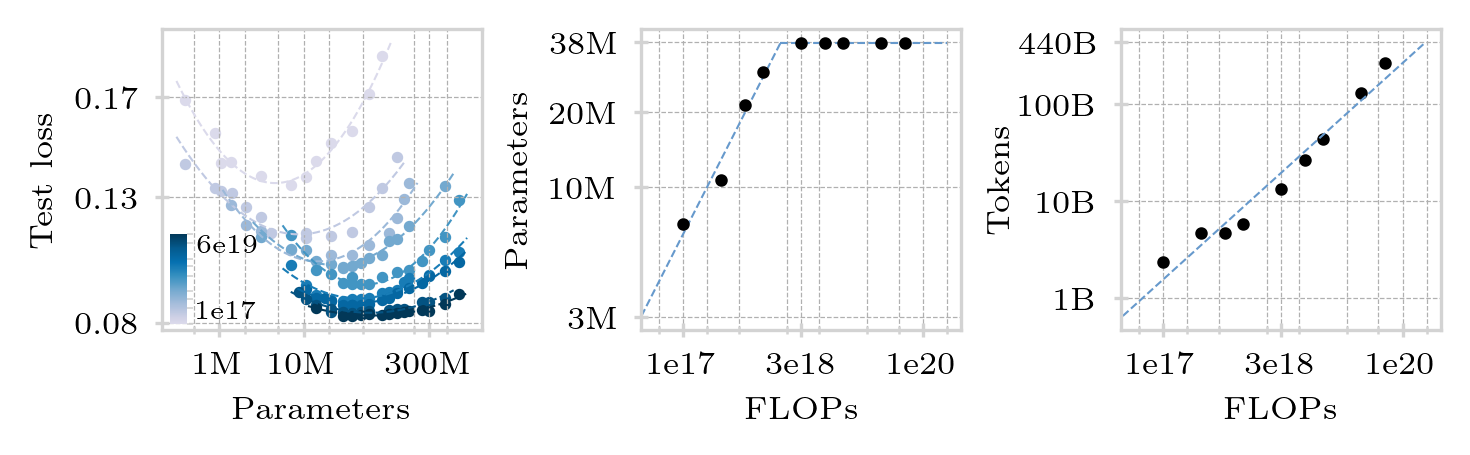

In [ ]:
# Plot

import wandb
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, LogFormatterMathtext, LogLocator
from matplotlib import cm
import os
from matplotlib.colors import LinearSegmentedColormap

def truncate_colormap(cmap, minval=0.2, maxval=1.0, n=100):
    return LinearSegmentedColormap.from_list(
        f"trunc({cmap.name},{minval},{maxval})",
        cmap(np.linspace(minval, maxval, n))
    )

# Settings
FONTSIZE = 7.7
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.serif': ['Computer Modern Roman'],
    'text.latex.preamble': r'\usepackage{amsmath} \usepackage{type1cm}',
    'font.size': FONTSIZE,
})

# Helpers 
def estimate_kaplan(n_layer, n_embd):
    return 12 * n_layer * n_embd**2

def format_large(x, _):
    if x >= 1e12:
        return f'{x*1e-12:.0f}T'
    elif x >= 1e9:
        return f'{x*1e-9:.0f}B'
    elif x >= 1e6:
        return f'{x*1e-6:.0f}M'
    else:
        return str(int(x))

# Load runs 
api = wandb.Api()
runs = api.runs("<W&B entity>/TRACE_RECONSTRUCTION")
compute_budgets = [1e17, 3e17, 6e17, 1e18, 3e18, 6e18, 1e19, 3e19, 6e19]  # Chinchilla-style C = 6*N*tokens

compute_points = {cb: [] for cb in compute_budgets}

for run in runs:
    if run.state != "finished":
        continue
    tags = run.tags or []
    # Find a gpt_* tag that ends in _final
    gpt_tag = next((t for t in tags if any(t.startswith(model) and t.endswith("_final") for model in gpt_models)), None)
    if not gpt_tag:
        continue

    # find all model-keys that are a prefix of this tag
    cands = [m for m in gpt_models if gpt_tag.startswith(m)]
    if not cands:
        continue

    # pick the longest one so Z2 wins over Z
    model_type = max(cands, key=len)
    parts = gpt_tag.split('_')
    compute_str = next((p for p in parts if 'e' in p), None)
    try:
        compute = float(compute_str)
    except:
        continue
    if compute not in compute_budgets:
        continue
    arch = gpt_models[model_type]
    N = estimate_kaplan(arch['n_layer'], arch['n_embd'])
    log_params = math.log10(N)
    loss = run.summary.get("test/loss", run.summary.get("val/loss", None))
    if loss is not None:
        compute_points[compute].append((log_params, loss, gpt_tag, run.name))

# Extract best runs 
min_loss_per_compute = {
    cb: min(pts, key=lambda x: x[1]) for cb, pts in compute_points.items() if pts
}

compute_vs_params = []
flops_vs_tokens = []
tags_list = []

for compute_budget, (log_params, loss, gpt_tag, run_name) in min_loss_per_compute.items():
    parts = gpt_tag.split('_')
    model_type = parts[0] + '_' + parts[1] if parts[1][0].isalpha() else parts[0]
    if model_type not in gpt_models:
        continue
    arch = gpt_models[model_type]
    N = estimate_kaplan(arch['n_layer'], arch['n_embd'])

    compute_vs_params.append((compute_budget, N))
    flops_vs_tokens.append((compute_budget, compute_budget / (6 * N)))
    tags_list.append(gpt_tag)

compute_vs_params = np.array(compute_vs_params)
flops_vs_tokens = np.array(flops_vs_tokens)

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import ticker, cm
import numpy as np

# Figure setup
fig, axes = plt.subplots(1, 3, figsize=(5.5, 1.3), dpi=300, gridspec_kw={'wspace': 0.5})
ax0, ax1, ax2 = axes

# Truncate PuBu to skip lightest colors (0.0–0.2) 
def truncate_colormap(cmap, minval=0.2, maxval=1.0, n=100):
    new_cmap = LinearSegmentedColormap.from_list(
        f"trunc({cmap.name},{minval},{maxval})",
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

trunc_cmap = truncate_colormap(cm.PuBu, minval=0.2, maxval=1.0)

norm = mpl.colors.LogNorm(vmin=min(compute_points.keys()), vmax=max(compute_points.keys()))
sm = plt.cm.ScalarMappable(cmap=trunc_cmap, norm=norm)
sm.set_array([])

# Plot 1: Test Loss vs Parameters 

colors = cm.PuBu(np.linspace(0.2, 1.0, len(compute_points)))

for idx, (compute_budget, points) in enumerate(compute_points.items()):
    if not points:
        continue
    x_log, y, tags, _ = zip(*points)
    color = colors[idx]
    x = [10**v for v in x_log]
    ax0.scatter(x, y, color=color, s=3)
    coeffs = np.polyfit(np.log10(x), y, deg=2)
    poly = np.poly1d(coeffs)
    x_fit = np.logspace(np.log10(min(x)) - 0.1, np.log10(max(x)) + 0.1, 200)
    y_fit = poly(np.log10(x_fit))
    ax0.plot(x_fit, y_fit, linestyle='--', color=color, linewidth=0.5)

ax0.set_xscale("log")
ax0.xaxis.set_minor_locator(LogLocator(base=10.0, subs=[2, 5], numticks=100))
ax0.xaxis.set_minor_formatter(ticker.NullFormatter())
ax0.set_xticks([1e6, 1e7, 3e8])
ax0.set_xticklabels(['1M', '10M', '300M'])
ax0.set_yticks([0.08, 0.13, 0.17])
ax0.set_yticklabels(['0.08', '0.13', '0.17'])
ax0.set_xlabel("Parameters")
ax0.set_ylabel("Test loss")
ax0.tick_params(axis='both', which='both', direction='inout')#, length=0.)
ax0.grid(True, which='both', ls='--', lw=0.3)

# Insert horizontal colorbar 
# Position of ax0
pos = ax0.get_position()

# Define colorbar position relative to figure
cbar_left = pos.x0 + 0.005   # % left of the first plot
cbar_bottom = pos.y0 + 0.015 
cbar_width = 0.01            # Thin
cbar_height = pos.height * 0.3   # Span ~30% of ax0

# Add colorbar
cbar_ax = fig.add_axes([cbar_left, cbar_bottom, cbar_width, cbar_height])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical')

# Set only 1e17 and 6e19 as major ticks with labels
cbar.set_ticks([1e17, 6e19])
cbar.set_ticklabels(['1e17', '6e19'], fontdict={'fontsize': 6.3})
# Minor ticks at 3e17, 6e17, etc.
minor_locator = ticker.FixedLocator([3e17, 6e17, 1e18, 3e18, 6e18, 1e19, 3e19])
cbar.ax.yaxis.set_minor_locator(minor_locator)

# Hide labels for minor ticks
cbar.ax.yaxis.set_minor_formatter(ticker.NullFormatter())

# Tick appearance lightgray ticks, black labels
cbar.ax.tick_params(axis='y', which='both', color='lightgray', labelcolor='black', size=1.5, width=0.4, pad=1)

# Align first label bottom, last label top
yticklabels = cbar.ax.get_yticklabels()
yticklabels[0].set_verticalalignment('bottom')
yticklabels[-1].set_verticalalignment('top')


# Style the colorbar
cbar.ax.tick_params(direction='out')
cbar.outline.set_visible(False)

# Plot 2: Compute vs Parameters
ax = axes[1]
x1, y1 = compute_vs_params[:,0], compute_vs_params[:,1]

n_fit = 4
logx = np.log10(x1[:n_fit])
logy = np.log10(y1[:n_fit])
slope, intercept = np.polyfit(logx, logy, 1)

x_break = x1[n_fit]
y_break = y1[n_fit]

x_hit = 10 ** ((np.log10(y_break) - intercept) / slope)

x_slope = np.logspace(np.log10(3e16), np.log10(x_hit), 200)

y_slope = 10**(intercept + slope * np.log10(x_slope))

x_plateau = np.logspace(np.log10(x_hit), np.log10(2e20), 200)
y_plateau = np.full_like(x_plateau, y_break)

ax.plot(x_slope, y_slope, '--', color='#6699CC', linewidth=0.5)
ax.plot(x_plateau, y_plateau, '--', color='#6699CC', linewidth=0.5)

ax.loglog(x1, y1, 'o', color='black', markersize=2)
ax.set_xticks([1e17, 3e18, 1e20])
ax.set_xticklabels(['1e17', '3e18', '1e20'])
ax.tick_params(axis='both', which='both', direction='inout') #, length=0)  # set length=0 to hide tick lines


# For x-axis minor ticks

ax.set_yticks([3_000_000, 10_000_000, 20_000_000, 38_000_000])
ax.set_yticklabels(['3M', '10M', '20M', '38M'])


ax.yaxis.set_minor_locator(plt.NullLocator())

ax.set_xlabel("FLOPs")
ax.set_ylabel("Parameters")
ax.tick_params(axis='both', which='major')
ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs=[2, 5], numticks=100))
ax.xaxis.set_minor_formatter(ticker.NullFormatter())
ax.grid(True, which='both', ls='--', lw=0.3)

ax.set_xlim([3e16, 3e20])


# Plot 3: Compute vs Tokens 
ax = axes[2]
x2, y2 = flops_vs_tokens[:,0], flops_vs_tokens[:,1]

ax.loglog(x2, y2, marker='o', linestyle='none', color='black', markersize=2)

slope, intercept = np.polyfit(np.log10(x2), np.log10(y2), 1)
x_fit = np.logspace(np.log10(min(x2)) - 0.5, np.log10(max(x2)) + 0.5, 100)
y_fit = 10**(slope * np.log10(x_fit) + intercept)
ax.plot(x_fit, y_fit, linestyle='--', color='#6699CC', linewidth=0.5)


ax.yaxis.set_minor_locator(plt.NullLocator())


ax.set_yticks([1e9, 10e9, 100e9, 440e9])
ax.set_yticklabels(['1B', '10B', '100B', '440B'])
ax.set_xticks([1e17, 3e18, 1e20])
ax.set_xticklabels(['1e17', '3e18', '1e20'])


ax.set_xlabel("FLOPs")
ax.set_ylabel("Tokens", labelpad=1)
ax.tick_params(axis='both', which='major')
ax.grid(True, which="both", ls="--", linewidth=0.3)
ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs=[2, 5], numticks=100))
ax.xaxis.set_minor_formatter(ticker.NullFormatter())

for ax in axes:
    for spine in ax.spines.values():
        spine.set_color('lightgray')  # Light gray frame

    # Make only the tick linesgray, but leave labels black
    ax.tick_params(axis='both', which='both', color='lightgray', labelcolor='black')

ax.tick_params(axis='both', which='both', direction='inout') #, length=0)  # set length=0 to hide tick lines

ax.set_xlim([3e16, 3e20])

# Ensure the 'plots' directory exists
os.makedirs('plots', exist_ok=True)

plt.tight_layout(w_pad=0.0)
plt.savefig('plots/scaling_laws.pdf', bbox_inches='tight')

plt.show()